# 프로야구선수 연봉 예측


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
# pd.get_dummies보다 어려움 but 메모리 차지 더 적음. 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
# 통계학 관련 함수

# matplotlib 한글깨짐 방지 폰트사용 
from matplotlib import font_manager, rc
import matplotlib
font_path = "C:/Windows/Fonts/malgun.ttf" # 맑은 고딕...
font_name = font_manager.FontProperties(fname=font_path).get_name()
matplotlib.rc("font", family=font_name)

## 1. 데이터 확인

In [2]:
pich = pd.read_csv("picher_stats_2017.csv")
pich.head()

,선수명,팀명,승,패,세,홀드,블론,경기,선발,이닝,...,홈런/9,BABIP,LOB%,ERA,RA9-WAR,FIP,kFIP,WAR,연봉(2018),연봉(2017)
0,켈리,SK,16,7,0,0,0,30,30,190.0,...,0.76,0.342,73.7,3.60,6.91,3.69,3.44,6.62,140000,85000
1,소사,LG,11,11,1,0,0,30,29,185.1,...,0.53,0.319,67.1,3.88,6.80,3.52,3.41,6.08,120000,50000
2,양현종,KIA,20,6,0,0,0,31,31,193.1,...,0.79,0.332,72.1,3.44,6.54,3.94,3.82,5.64,230000,150000
3,차우찬,LG,10,7,0,0,0,28,28,175.2,...,1.02,0.298,75.0,3.43,6.11,4.20,4.03,4.63,100000,100000
4,레일리,롯데,13,7,0,0,0,30,30,187.1,...,0.91,0.323,74.1,3.80,6.13,4.36,4.31,4.38,111000,85000


In [3]:
pich.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 22 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   선수명       152 non-null    object 
 1   팀명        152 non-null    object 
 2   승         152 non-null    int64  
 3   패         152 non-null    int64  
 4   세         152 non-null    int64  
 5   홀드        152 non-null    int64  
 6   블론        152 non-null    int64  
 7   경기        152 non-null    int64  
 8   선발        152 non-null    int64  
 9   이닝        152 non-null    float64
 10  삼진/9      152 non-null    float64
 11  볼넷/9      152 non-null    float64
 12  홈런/9      152 non-null    float64
 13  BABIP     152 non-null    float64
 14  LOB%      152 non-null    float64
 15  ERA       152 non-null    float64
 16  RA9-WAR   152 non-null    float64
 17  FIP       152 non-null    float64
 18  kFIP      152 non-null    float64
 19  WAR       152 non-null    float64
 20  연봉(2018)  152 non-null    int64 

In [5]:
pich.describe()

,승,패,세,홀드,블론,경기,선발,이닝,삼진/9,볼넷/9,홈런/9,BABIP,LOB%,ERA,RA9-WAR,FIP,kFIP,WAR,연봉(2018),연봉(2017)
count,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000
mean,3.197368,3.157895,1.473684,2.644737,0.888158,28.848684,6.092105,56.953947,7.049605,4.183289,1.209934,0.340507,68.523026,6.046053,1.056908,5.506842,5.536776,0.665921,18932.236842,16505.263158
std,3.863635,3.130929,4.808860,4.515474,1.633869,19.371502,9.750093,50.297632,2.827552,2.362819,1.017072,0.088985,11.591590,4.166645,1.843708,1.871047,1.981596,1.322205,30940.732924,25046.478092
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,35.700000,0.000000,-1.210000,0.730000,-0.690000,-1.010000,2700.000000,2700.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,0.000000,19.900000,5.492500,2.585000,0.690000,0.303750,62.400000,4.082500,-0.092500,4.437500,4.347500,-0.060000,4000.000000,3000.000000
50%,2.000000,2.000000,0.000000,0.000000,0.000000,26.000000,0.000000,43.700000,6.900000,3.750000,1.070000,0.333000,68.250000,5.355000,0.330000,5.210000,5.320000,0.130000,7550.000000,6000.000000
75%,5.000000,6.000000,0.000000,3.000000,1.000000,41.000000,7.000000,80.325000,8.212500,5.262500,1.550000,0.364000,74.525000,7.055000,1.522500,6.392500,6.570000,0.930000,18500.000000,15250.000000
max,20.000000,12.000000,37.000000,24.000000,7.000000,75.000000,31.000000,193.100000,22.500000,18.000000,9.000000,0.833000,100.000000,36.000000,7.280000,18.730000,17.600000,6.620000,230000.000000,150000.000000


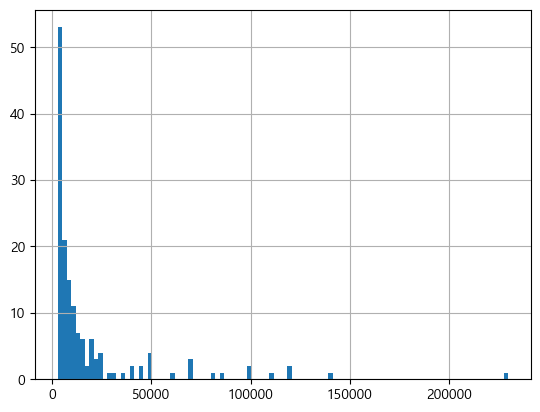

In [4]:
# 2018년 투수 연봉 분포 히스토그램
pich['연봉(2018)'].hist(bins=100)
plt.show()

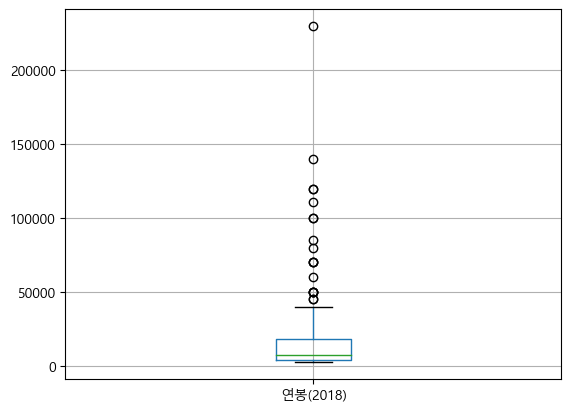

In [7]:
# 2018년 연봉의 상자 그림 출력 
pich.boxplot(column=['연봉(2018)'])
plt.show()

- 종속 변수 분석 
    - 수십억의 연봉을 받는 프로 야구선수는 많지 않으며, 5억원 미만의 연봉이 일반적임. 

In [10]:
pich[pich['연봉(2018)']==pich['연봉(2018)'].max()]

,선수명,팀명,승,패,세,홀드,블론,경기,선발,이닝,...,홈런/9,BABIP,LOB%,ERA,RA9-WAR,FIP,kFIP,WAR,연봉(2018),연봉(2017)
2,양현종,KIA,20,6,0,0,0,31,31,193.1,...,0.79,0.332,72.1,3.44,6.54,3.94,3.82,5.64,230000,150000


In [5]:
# 선수명, 팀명과 같이 그래프로 표현할 수 없는 피처 제외하고 시각화
vis_pich = pich.iloc[:, 2:]
vis_pich.head()

,승,패,세,홀드,블론,경기,선발,이닝,삼진/9,볼넷/9,홈런/9,BABIP,LOB%,ERA,RA9-WAR,FIP,kFIP,WAR,연봉(2018),연봉(2017)
0,16,7,0,0,0,30,30,190.0,8.95,2.13,0.76,0.342,73.7,3.60,6.91,3.69,3.44,6.62,140000,85000
1,11,11,1,0,0,30,29,185.1,7.43,1.85,0.53,0.319,67.1,3.88,6.80,3.52,3.41,6.08,120000,50000
2,20,6,0,0,0,31,31,193.1,7.36,2.09,0.79,0.332,72.1,3.44,6.54,3.94,3.82,5.64,230000,150000
3,10,7,0,0,0,28,28,175.2,8.04,1.95,1.02,0.298,75.0,3.43,6.11,4.20,4.03,4.63,100000,100000
4,13,7,0,0,0,30,30,187.1,7.49,2.11,0.91,0.323,74.1,3.80,6.13,4.36,4.31,4.38,111000,85000


In [6]:
# 피처 각각에 대한 히스토그램 출력 
def plot_hist(df):
    
    # matplotlib 자체 환경 설정 
    plt.rcParams['figure.figsize'] = [20,16]
    fig = plt.figure()
    
    # df의 열 개수만큼의 subplot을 출력
    for i in range(len(df.columns)):
        ax = fig.add_subplot(5,5,i+1)
        plt.hist(df[df.columns[i]], bins=50)
        ax.set_title(df.columns[i])
        
    plt.tight_layout()
    # 간격 겹쳐지지 않게 
    plt.show()

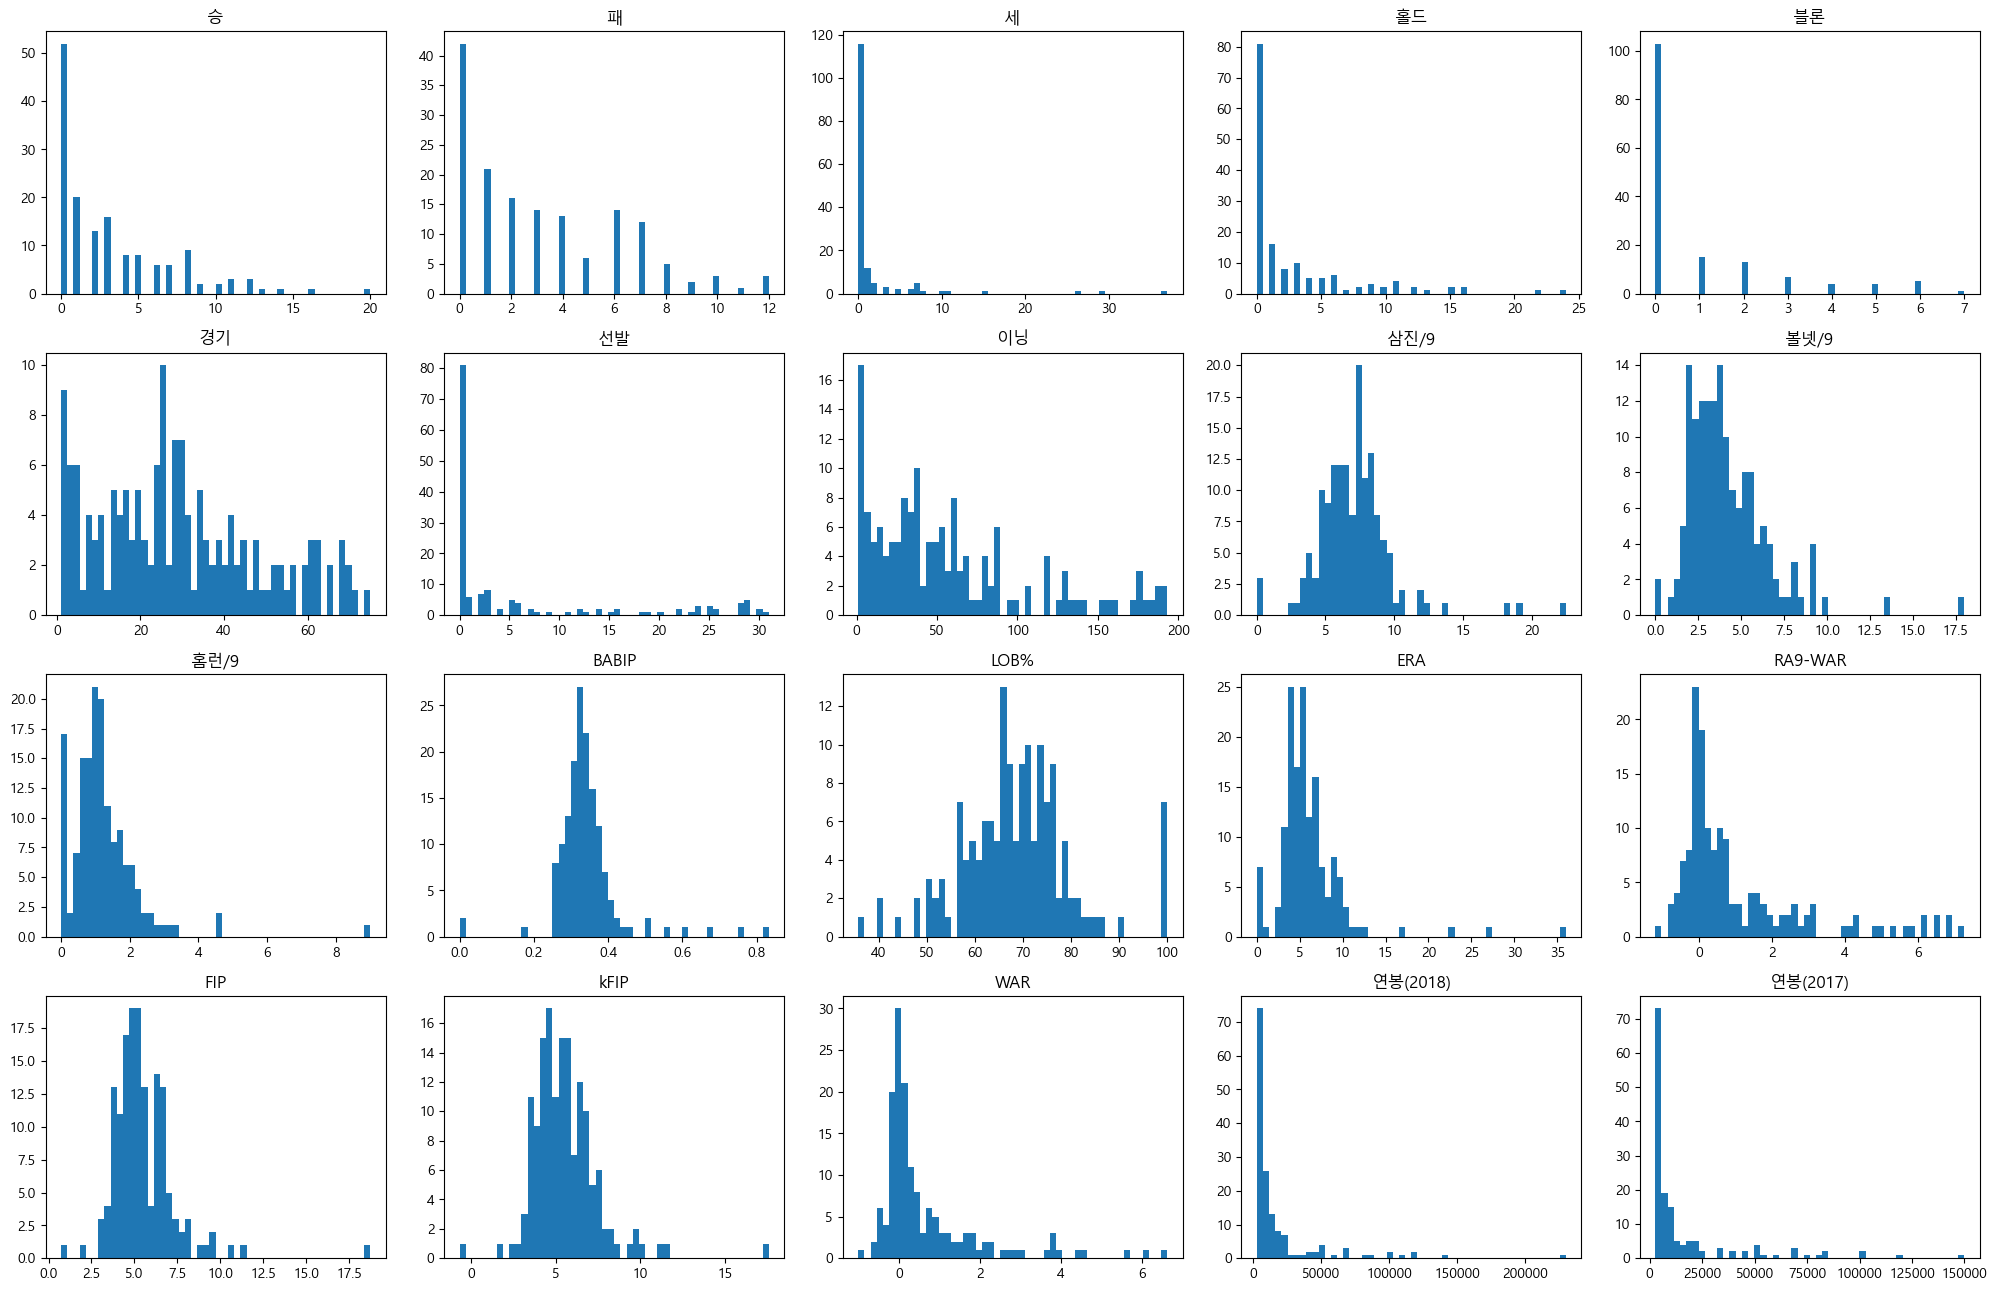

In [7]:
plot_hist(vis_pich)

- 매우 불균형한 분포를 가지고 있는 피처들 많음.
- 각 피처 간의 단위가 많이 다름.
    - 스케일링 필요
        - 선형회귀도 단위가 큰 데이터의 영향을 크게 받을 수 있음.

## 2. 데이터 전처리

### 스케일링

In [8]:
scale_col = pich.columns[2:].tolist()

# 종속변수는 스케일링 하지 않음.
scale_col.remove("연봉(2018)")
scale_col

['승',
 '패',
 '세',
 '홀드',
 '블론',
 '경기',
 '선발',
 '이닝',
 '삼진/9',
 '볼넷/9',
 '홈런/9',
 'BABIP',
 'LOB%',
 'ERA',
 'RA9-WAR',
 'FIP',
 'kFIP',
 'WAR',
 '연봉(2017)']

In [9]:
pich[scale_col].head()

,승,패,세,홀드,블론,경기,선발,이닝,삼진/9,볼넷/9,홈런/9,BABIP,LOB%,ERA,RA9-WAR,FIP,kFIP,WAR,연봉(2017)
0,16,7,0,0,0,30,30,190.0,8.95,2.13,0.76,0.342,73.7,3.60,6.91,3.69,3.44,6.62,85000
1,11,11,1,0,0,30,29,185.1,7.43,1.85,0.53,0.319,67.1,3.88,6.80,3.52,3.41,6.08,50000
2,20,6,0,0,0,31,31,193.1,7.36,2.09,0.79,0.332,72.1,3.44,6.54,3.94,3.82,5.64,150000
3,10,7,0,0,0,28,28,175.2,8.04,1.95,1.02,0.298,75.0,3.43,6.11,4.20,4.03,4.63,100000
4,13,7,0,0,0,30,30,187.1,7.49,2.11,0.91,0.323,74.1,3.80,6.13,4.36,4.31,4.38,85000


In [10]:
pich_ss = StandardScaler()

scaled_pich = pich_ss.fit_transform(pich[scale_col])
scaled_pich

array([[ 3.32457765,  1.23120199, -0.30746498, ..., -1.06162315,
         4.51802888,  2.74374569],
       [ 2.02618144,  2.51300132, -0.09882803, ..., -1.07681252,
         4.10827019,  1.34172411],
       [ 4.36329461,  0.91075216, -0.30746498, ..., -0.86922457,
         3.77439273,  5.34750005],
       ...,
       [-0.8302902 , -0.37104718, -0.30746498, ...,  1.39399038,
        -0.9681847 , -0.02023971],
       [-0.8302902 , -0.05059734, -0.30746498, ...,  0.71553221,
        -1.03647782, -0.54499636],
       [ 0.20842676,  0.26985249, -0.30746498, ...,  1.15096059,
        -1.27170966, -0.54099058]])

In [11]:
scaled_pich_df = pd.DataFrame(scaled_pich, columns=scale_col)
scaled_pich_df.head()

,승,패,세,홀드,블론,경기,선발,이닝,삼진/9,볼넷/9,홈런/9,BABIP,LOB%,ERA,RA9-WAR,FIP,kFIP,WAR,연봉(2017)
0,3.324578,1.231202,-0.307465,-0.587641,-0.545389,0.059630,2.460174,2.653920,0.674321,-0.871873,-0.443844,0.016838,0.448091,-0.588996,3.185125,-0.974240,-1.061623,4.518029,2.743746
1,2.026181,2.513001,-0.098828,-0.587641,-0.545389,0.059630,2.357272,2.556178,0.134976,-0.990767,-0.670731,-0.242485,-0.123170,-0.521574,3.125265,-1.065398,-1.076813,4.108270,1.341724
2,4.363295,0.910752,-0.307465,-0.587641,-0.545389,0.111423,2.563077,2.715757,0.110138,-0.888857,-0.414250,-0.095911,0.309604,-0.627523,2.983779,-0.840183,-0.869225,3.774393,5.347500
3,1.766502,1.231202,-0.307465,-0.587641,-0.545389,-0.043956,2.254370,2.358699,0.351424,-0.948305,-0.187363,-0.479259,0.560612,-0.629931,2.749783,-0.700764,-0.762899,3.007992,3.344612
4,2.545540,1.231202,-0.307465,-0.587641,-0.545389,0.059630,2.460174,2.596072,0.156266,-0.880365,-0.295875,-0.197386,0.482713,-0.540837,2.760666,-0.614968,-0.621132,2.818289,2.743746


In [12]:
scaled_pich_df = pd.concat([pich[['선수명','팀명','연봉(2018)']],
                           scaled_pich_df], axis=1)
scaled_pich_df.head()

,선수명,팀명,연봉(2018),승,패,세,홀드,블론,경기,선발,...,볼넷/9,홈런/9,BABIP,LOB%,ERA,RA9-WAR,FIP,kFIP,WAR,연봉(2017)
0,켈리,SK,140000,3.324578,1.231202,-0.307465,-0.587641,-0.545389,0.059630,2.460174,...,-0.871873,-0.443844,0.016838,0.448091,-0.588996,3.185125,-0.974240,-1.061623,4.518029,2.743746
1,소사,LG,120000,2.026181,2.513001,-0.098828,-0.587641,-0.545389,0.059630,2.357272,...,-0.990767,-0.670731,-0.242485,-0.123170,-0.521574,3.125265,-1.065398,-1.076813,4.108270,1.341724
2,양현종,KIA,230000,4.363295,0.910752,-0.307465,-0.587641,-0.545389,0.111423,2.563077,...,-0.888857,-0.414250,-0.095911,0.309604,-0.627523,2.983779,-0.840183,-0.869225,3.774393,5.347500
3,차우찬,LG,100000,1.766502,1.231202,-0.307465,-0.587641,-0.545389,-0.043956,2.254370,...,-0.948305,-0.187363,-0.479259,0.560612,-0.629931,2.749783,-0.700764,-0.762899,3.007992,3.344612
4,레일리,롯데,111000,2.545540,1.231202,-0.307465,-0.587641,-0.545389,0.059630,2.460174,...,-0.880365,-0.295875,-0.197386,0.482713,-0.540837,2.760666,-0.614968,-0.621132,2.818289,2.743746


### 원핫인코딩

In [13]:
scaled_pich_df['팀명'].unique()

array(['SK', 'LG', 'KIA', '롯데', 'KT', '두산', '삼성', '한화', 'NC'],
      dtype=object)

In [14]:
ohe = OneHotEncoder()

team_arr = np.array(scaled_pich_df['팀명'])
# 사이킷런 OneHotEncoder 쓰려면
# 2차원 데이터로 만들어줘야 함 
team_arr = np.reshape(team_arr, (-1,1))

team_name = ohe.fit_transform(team_arr)
team_name

<152x9 sparse matrix of type '<class 'numpy.float64'>'
	with 152 stored elements in Compressed Sparse Row format>

In [15]:
ohe.get_feature_names()

C:\Users\answl\anaconda3\envs\nlp\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


array(['x0_KIA', 'x0_KT', 'x0_LG', 'x0_NC', 'x0_SK', 'x0_두산', 'x0_롯데',
       'x0_삼성', 'x0_한화'], dtype=object)

In [16]:
ohe_team_df = pd.DataFrame(team_name.toarray(),
                          columns=ohe.get_feature_names())
ohe_team_df.head()

,x0_KIA,x0_KT,x0_LG,x0_NC,x0_SK,x0_두산,x0_롯데,x0_삼성,x0_한화
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [17]:
scaled_pich_df = pd.concat([scaled_pich_df, ohe_team_df], axis=1)
scaled_pich_df.tail()

,선수명,팀명,연봉(2018),승,패,세,홀드,블론,경기,선발,...,연봉(2017),x0_KIA,x0_KT,x0_LG,x0_NC,x0_SK,x0_두산,x0_롯데,x0_삼성,x0_한화
147,장민재,한화,7100,-0.310932,0.590302,-0.307465,-0.587641,0.682746,0.215009,-0.112380,...,-0.336696,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
148,정용운,KIA,7500,-0.051252,-0.371047,-0.307465,-0.587641,-0.545389,-0.199334,0.505033,...,-0.536985,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
149,노경은,롯데,10000,-0.830290,-0.371047,-0.307465,-0.587641,-0.545389,-1.028020,-0.421087,...,-0.020240,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
150,김승현,삼성,4000,-0.830290,-0.050597,-0.307465,-0.365449,-0.545389,0.629352,-0.626891,...,-0.544996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
151,류희운,KT,4000,0.208427,0.269852,-0.307465,-0.587641,-0.545389,-0.251127,0.813740,...,-0.540991,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
scaled_pich_df = scaled_pich_df.drop('팀명', axis=1)
scaled_pich_df.head()

,선수명,연봉(2018),승,패,세,홀드,블론,경기,선발,이닝,...,연봉(2017),x0_KIA,x0_KT,x0_LG,x0_NC,x0_SK,x0_두산,x0_롯데,x0_삼성,x0_한화
0,켈리,140000,3.324578,1.231202,-0.307465,-0.587641,-0.545389,0.059630,2.460174,2.653920,...,2.743746,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,소사,120000,2.026181,2.513001,-0.098828,-0.587641,-0.545389,0.059630,2.357272,2.556178,...,1.341724,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,양현종,230000,4.363295,0.910752,-0.307465,-0.587641,-0.545389,0.111423,2.563077,2.715757,...,5.347500,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,차우찬,100000,1.766502,1.231202,-0.307465,-0.587641,-0.545389,-0.043956,2.254370,2.358699,...,3.344612,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,레일리,111000,2.545540,1.231202,-0.307465,-0.587641,-0.545389,0.059630,2.460174,2.596072,...,2.743746,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## 3. 데이터 분할

In [19]:
x = scaled_pich_df.iloc[:,2:]
y = scaled_pich_df['연봉(2018)']

x.head()

,승,패,세,홀드,블론,경기,선발,이닝,삼진/9,볼넷/9,...,연봉(2017),x0_KIA,x0_KT,x0_LG,x0_NC,x0_SK,x0_두산,x0_롯데,x0_삼성,x0_한화
0,3.324578,1.231202,-0.307465,-0.587641,-0.545389,0.059630,2.460174,2.653920,0.674321,-0.871873,...,2.743746,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,2.026181,2.513001,-0.098828,-0.587641,-0.545389,0.059630,2.357272,2.556178,0.134976,-0.990767,...,1.341724,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.363295,0.910752,-0.307465,-0.587641,-0.545389,0.111423,2.563077,2.715757,0.110138,-0.888857,...,5.347500,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.766502,1.231202,-0.307465,-0.587641,-0.545389,-0.043956,2.254370,2.358699,0.351424,-0.948305,...,3.344612,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.545540,1.231202,-0.307465,-0.587641,-0.545389,0.059630,2.460174,2.596072,0.156266,-0.880365,...,2.743746,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [20]:
x_train, x_test, y_train, y_test = train_test_split(x,y,
                                                   test_size=0.2,
                                                   random_state=4)

## 4. 모델 훈련

In [21]:
lr = LinearRegression()

lr.fit(x_train, y_train)

LinearRegression()

In [22]:
# 회귀식 계수 확인
lr.coef_

array([  1827.07812958,   -999.68575045,    246.18597066,    628.02371828,
         1041.26589339,  -4861.63900115,  -7947.53826078,   9302.74380269,
         3304.14866341,   4394.2679301 ,  10753.40487691,  -1256.03037593,
         -353.66343283,    479.71403904,  -1162.40128514, -57983.85138932,
        48483.39574941,  10279.32098102,  18412.10548613,   -935.88848592,
         -596.79239777,   2202.51351102,  -1600.37213748,    899.27189839,
        -1682.11474049,    504.03684138,  -1584.01030887,   2793.35581975])

In [23]:
lr.intercept_

18410.522443089914

## 5. 모델 평가

In [24]:
# 결정계수
lr.score(x_test, y_test)

0.8935744649952289

In [25]:
lr.score(x_train,y_train)

0.9247449540993224

In [26]:
pred = lr.predict(x_test)
# 실제값-예측값 간 평균절대오차 
mae = mean_absolute_error(y_test, pred)
mae # 평균적으로 연봉 7천만원 차이 

7083.340818906982

## 6. 모델 최적화

In [27]:
import statsmodels.api as sm

In [28]:
# statsmodels 라이브러리로 회귀 분석 
# 직접 상수항 (y절편) 추가 
x = sm.add_constant(x)

model = sm.OLS(y,x) # 최소자승법--> 선형회귀
# sm.Logit(y,x) : 로지스틱회귀 
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               연봉(2018)   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     58.29
Date:                Thu, 29 Jun 2023   Prob (F-statistic):           7.23e-58
Time:                        10:07:39   Log-Likelihood:                -1588.0
No. Observations:                 152   AIC:                             3232.
Df Residuals:                     124   BIC:                             3317.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.694e+04    683.418     24.785      0.000    1.56e+04    1.83e+04
승           4318.6495   2112.857      2.044      0.043     136.713    8500.586
패           -775.3896   1815.354     -0.427      0.670   -4368.484    2817.705
세           -145.5707   1322.179     -0.110      0.913   -2762.533    2471.392
홀드           -89.3023   1452.247     -0.061      0.951   -2963.707    2785.102
블론           355.6897   1291.953      0.275      0.784   -2201.447    2912.826
경기         -3223.9728   2861.782     -1.127      0.262   -8888.241    2440.295
선발         -7208.3074   4708.973     -1.531      0.128   -1.65e+04    2112.070
이닝          4317.7744   5978.890      0.722      0.472   -7516.123    1.62e+04
삼진/9       -2238.6095   7079.857     -0.316      0.752   -1.63e+04    1.18e+04
볼넷/9        1621.7193   5692.006      0.285      0.776   -9644.354    1.29e+04
홈런/9         374.3384   1.54e+04      0.024      0.981   -3.02e+04    3.09e+04
BABIP      -1173.3680   1340.473     -0.875      0.383   -3826.540    1479.804
LOB%          97.9049   1552.150      0.063      0.950   -2974.236    3170.045
ERA          296.5873   2440.574      0.122      0.903   -4533.992    5127.167
RA9-WAR    -1435.7086   2755.134     -0.521      0.603   -6888.891    4017.473
FIP         7954.1995   8.93e+04      0.089      0.929   -1.69e+05    1.85e+05
kFIP       -8363.4005   7.58e+04     -0.110      0.912   -1.58e+05    1.42e+05
WAR         1.118e+04   2408.930      4.641      0.000    6412.869    1.59e+04
연봉(2017)     2.19e+04   1181.835     18.529      0.000    1.96e+04    2.42e+04
x0_KIA      3639.5237   2365.807      1.538      0.127   -1043.071    8322.118
x0_KT       4180.9928   2162.716      1.933      0.055     -99.628    8461.613
x0_LG       2509.1647   2189.710      1.146      0.254   -1824.885    6843.214
x0_NC        698.1140   2575.804      0.271      0.787   -4400.123    5796.351
x0_SK       3131.2334   2216.873      1.412      0.160   -1256.580    7519.047
x0_두산      -2681.2019   2497.556     -1.074      0.285   -7624.565    2262.161
x0_롯데       1759.2582   2450.085      0.718      0.474   -3090.147    6608.664
x0_삼성       -422.5088   2213.839     -0.191      0.849   -4804.317    3959.299
x0_한화       4123.7713   2110.662      1.954      0.053     -53.820    8301.363
==============================================================================
Omnibus:                       42.793   Durbin-Watson:                   1.694
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              713.491
Skew:                           0.302   Prob(JB):                    1.17e-155
Kurtosis:                      13.597   Cond. No.                     2.55e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is co

- R-squared 가 결정계수 (score)
- 칼럼이 많아질수록 결정계수 오차가 생김 --> 수정한것이 "Adjusted R-Squared"
- F-statistic : 유의성 검정 --> 이것만으로는 유의미한 차인지 아닌지 해석 불가능 --> Prob 확인 필요 (p값)
    - 보통 0.05 이하면 회귀분석이 유의미한 결과를 가짐.
    - 꽤나 유의미한 모델이 만들어졌다. 
    - 실제론 유의미하지 않은데 마치 우연인것처럼 연봉이 유의미하게 보일 확률이 굉장히 작다.
- P > |t| : 각각의 칼럼이 유의미한가
    - ex. 홈런 횟수는 연봉과 유의미한 연관성이 없다. 

1) F-statistic : 회귀식의 유의성 검정에 사용되는 값으로, Prob(F-statistic)과 함께 해석해야 함. 

2) prob(F-statistic) : F통계량에 대한 p-value. 일반적으로 0.05 이하면 회귀 분석이 유의미한 의미를 가진다. (전체 모델에 대한 유의성)

3) P > |t| : 각 피처가 얼마나 유의미한지를 나타내는 p-value

C:\Users\answl\anaconda3\envs\nlp\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


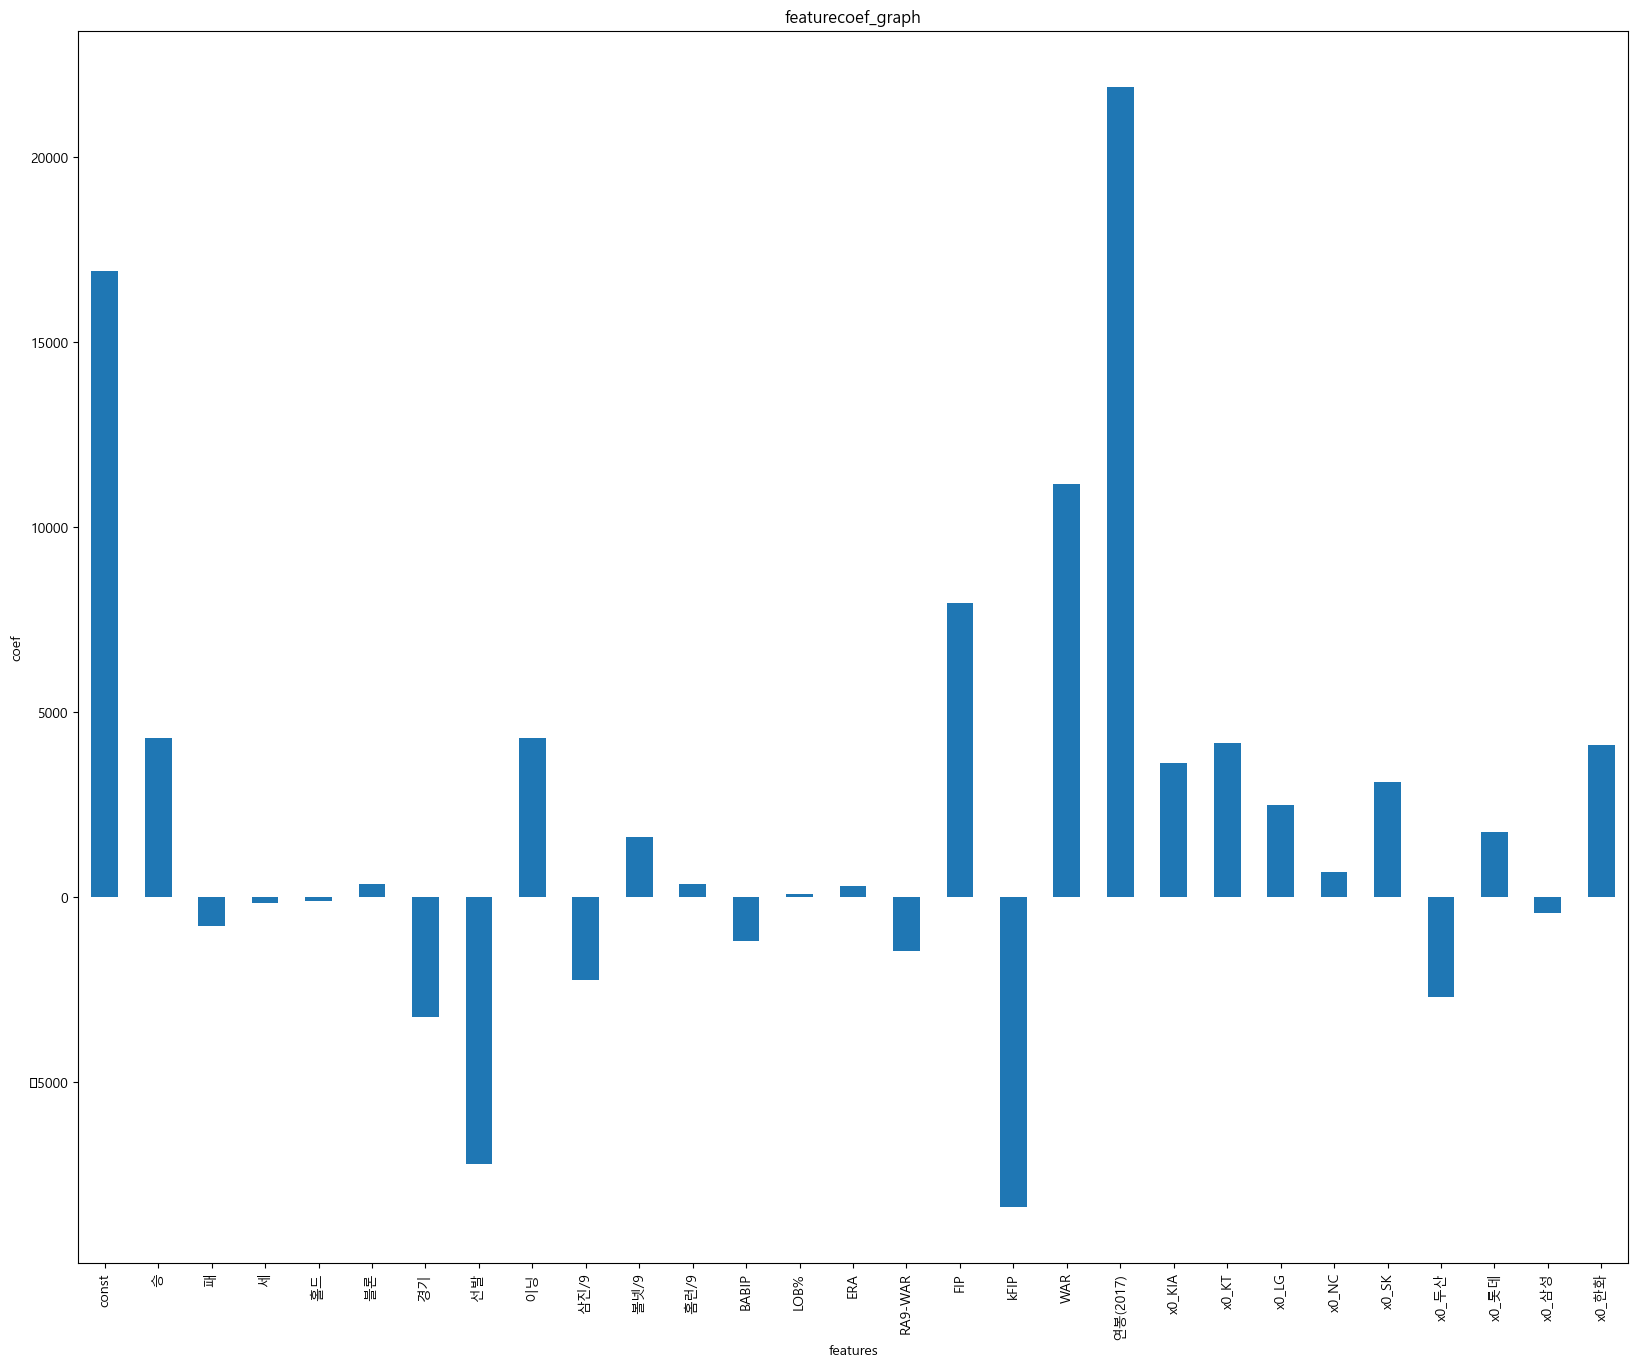

In [29]:
# 계수 시각화
# 회귀 계수를 시리즈로 변환 
coefs = model.params.tolist()
coefs_se = pd.Series(coefs)

# 변수명을 리스트로 반환
x_labels = model.params.index.tolist()

ax = coefs_se.plot(kind='bar')
ax.set_title('featurecoef_graph')
ax.set_xlabel('features')
ax.set_ylabel('coef')
ax.set_xticklabels(x_labels)

plt.show()

- 스케일링 했음에도 불구하고, 전년도 연봉에 민감하게 반응하고 있음. 
- 낮은 것들 (홈런 등) p값과 같이 확인하며 변수 제거 가능! 

In [30]:
model.params # 기울기들 

const       16938.347354
승            4318.649530
패            -775.389644
세            -145.570668
홀드            -89.302316
블론            355.689706
경기          -3223.972819
선발          -7208.307405
이닝           4317.774430
삼진/9        -2238.609542
볼넷/9         1621.719269
홈런/9          374.338396
BABIP       -1173.368024
LOB%           97.904862
ERA           296.587322
RA9-WAR     -1435.708574
FIP          7954.199537
kFIP        -8363.400532
WAR         11180.816471
연봉(2017)    21898.446610
x0_KIA       3639.523656
x0_KT        4180.992773
x0_LG        2509.164731
x0_NC         698.113956
x0_SK        3131.233374
x0_두산       -2681.201904
x0_롯데        1759.258230
x0_삼성        -422.508779
x0_한화        4123.771316
dtype: float64

In [31]:
model.params.index

Index(['const', '승', '패', '세', '홀드', '블론', '경기', '선발', '이닝', '삼진/9', '볼넷/9',
       '홈런/9', 'BABIP', 'LOB%', 'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WAR',
       '연봉(2017)', 'x0_KIA', 'x0_KT', 'x0_LG', 'x0_NC', 'x0_SK', 'x0_두산',
       'x0_롯데', 'x0_삼성', 'x0_한화'],
      dtype='object')

C:\Users\answl\anaconda3\envs\nlp\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()
C:\Users\answl\anaconda3\envs\nlp\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  if __name__ == "__main__":


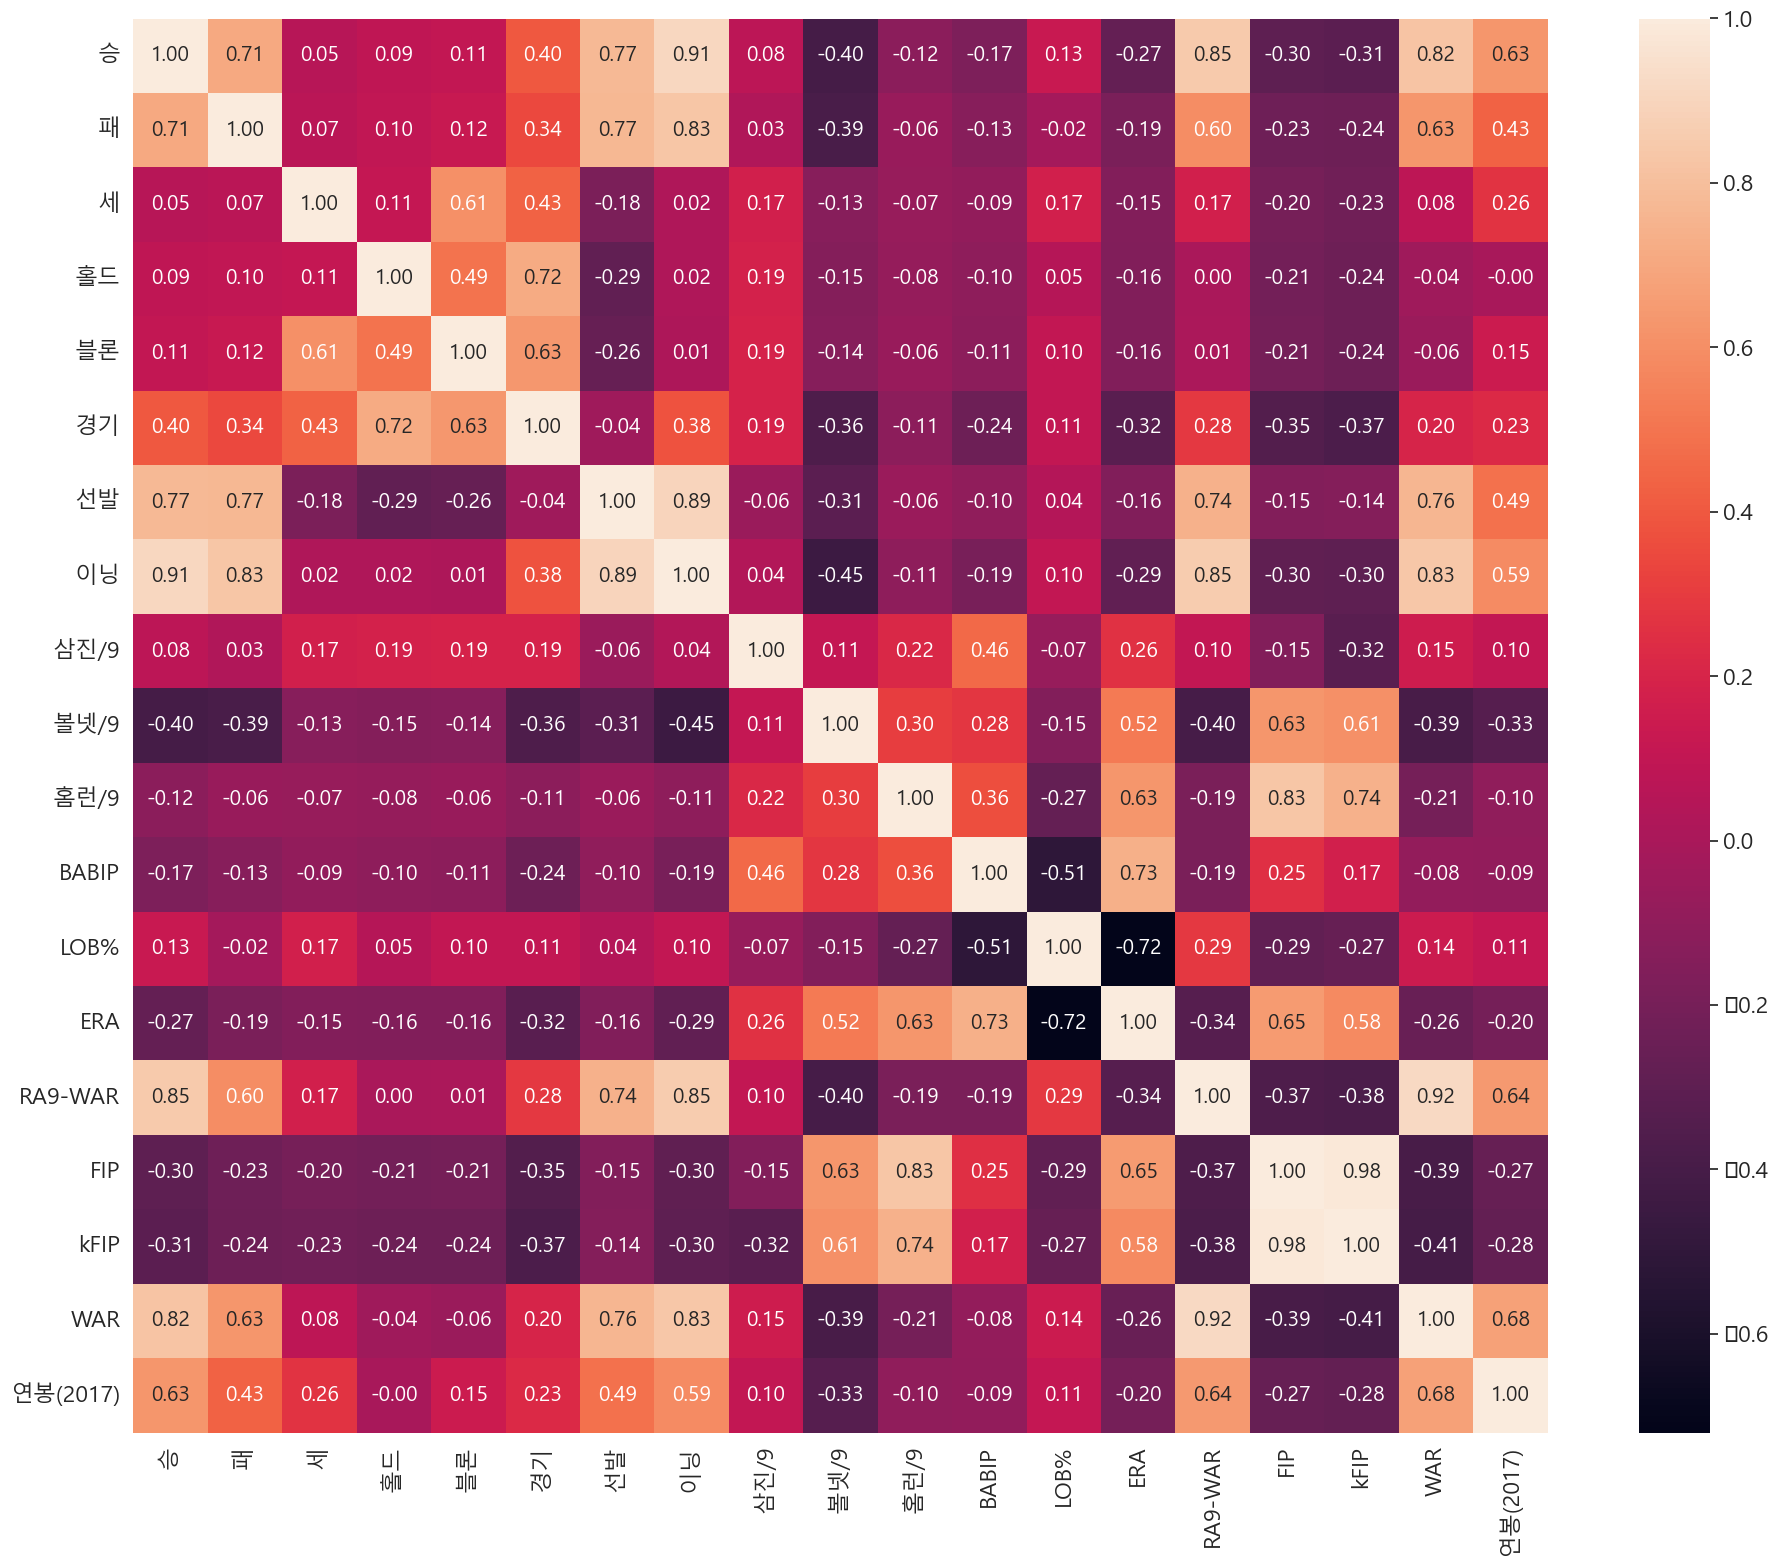

In [34]:
# 피처들의 상관관계 시각화
corr = scaled_pich_df[scale_col].corr()
# 종속변수, 범주형 변수 빠진 애들: scale_col
# 다중 공선성 빼기 위해 

sns.set(font_scale=1.5, font='Malgun Gothic')
hm = sns.heatmap(corr.values, cbar=True, annot=True,
                square=True, fmt='.2f', annot_kws={'size':15},
                yticklabels=scale_col, xticklabels=scale_col)

plt.tight_layout()
plt.show()

- 대략 0.7 기준보다 상관관계가 높으면 좋지 않은 것 ! 
- 몇몇 피처 쌍에서 높은 연관성을 발견할 수 있음. 
- 회귀 분석은 "피처 간의 독립성"을 전제로 하는 분석이기 때문에
- 올바른 회귀 분석을 위해서는 연관성이 높은 피처쌍을 제거해야함. 
    - [다중 공선성]
        - 변수 간 상관관계가 높아서 분석에 부정적인 영향을 미치는 것 
        - 모델 성능을 위해 어떤 피처를 제거하는 것이 옳은 판단일지에 대한 기준을 제시 가능 
        - 다중 공선성은 분산팽창요인(Variance Inflation Factor(VIF))이라는 계수로 평가
            - 일반적으로 VIF가 "15"를 넘으면 다중 공선성의 문제가 발생했다고 판단함. (업계 표준은 아님) 
            - 빡빡하게는 5, 널널하게는 15 (누가봐도 이상함)

In [35]:
scale_col

['승',
 '패',
 '세',
 '홀드',
 '블론',
 '경기',
 '선발',
 '이닝',
 '삼진/9',
 '볼넷/9',
 '홈런/9',
 'BABIP',
 'LOB%',
 'ERA',
 'RA9-WAR',
 'FIP',
 'kFIP',
 'WAR',
 '연봉(2017)']

In [36]:
corr

,승,패,세,홀드,블론,경기,선발,이닝,삼진/9,볼넷/9,홈런/9,BABIP,LOB%,ERA,RA9-WAR,FIP,kFIP,WAR,연봉(2017)
승,1.000000,0.710749,0.053747,0.092872,0.105281,0.397074,0.773560,0.906093,0.078377,-0.404710,-0.116147,-0.171111,0.131178,-0.271086,0.851350,-0.303133,-0.314159,0.821420,0.629710
패,0.710749,1.000000,0.066256,0.098617,0.121283,0.343147,0.771395,0.829018,0.031755,-0.386313,-0.064467,-0.133354,-0.020994,-0.188036,0.595989,-0.233416,-0.238688,0.625641,0.429227
세,0.053747,0.066256,1.000000,0.112716,0.605229,0.434290,-0.177069,0.020278,0.170436,-0.131394,-0.073111,-0.089212,0.167557,-0.150348,0.167669,-0.199746,-0.225259,0.084151,0.262664
홀드,0.092872,0.098617,0.112716,1.000000,0.490076,0.715527,-0.285204,0.024631,0.186790,-0.146806,-0.076475,-0.104307,0.048123,-0.155712,0.003526,-0.211515,-0.237353,-0.038613,-0.001213
블론,0.105281,0.121283,0.605229,0.490076,1.000000,0.630526,-0.264160,0.014176,0.188423,-0.137019,-0.064804,-0.112480,0.100633,-0.160761,0.008766,-0.209014,-0.237815,-0.058213,0.146584
경기,0.397074,0.343147,0.434290,0.715527,0.630526,1.000000,-0.037443,0.376378,0.192487,-0.364293,-0.113545,-0.241608,0.105762,-0.320177,0.281595,-0.345351,-0.373777,0.197836,0.225357
선발,0.773560,0.771395,-0.177069,-0.285204,-0.264160,-0.037443,1.000000,0.894018,-0.055364,-0.312935,-0.058120,-0.098909,0.041819,-0.157775,0.742258,-0.151040,-0.142685,0.758846,0.488559
이닝,0.906093,0.829018,0.020278,0.024631,0.014176,0.376378,0.894018,1.000000,0.037343,-0.451101,-0.107063,-0.191514,0.103369,-0.285392,0.853354,-0.296768,-0.302288,0.832609,0.586874
삼진/9,0.078377,0.031755,0.170436,0.186790,0.188423,0.192487,-0.055364,0.037343,1.000000,0.109345,0.216017,0.457523,-0.071284,0.256840,0.102963,-0.154857,-0.317594,0.151791,0.104948
볼넷/9,-0.404710,-0.386313,-0.131394,-0.146806,-0.137019,-0.364293,-0.312935,-0.451101,0.109345,1.000000,0.302251,0.276009,-0.150837,0.521039,-0.398586,0.629833,0.605008,-0.394131,-0.332379


In [38]:
# 피처마다 VIF 계수 출력 
vif = pd.DataFrame()

# from statsmodels.stats.outliers_influence 
# import variance_inflation_factor
vif['feature'] = x.columns
vif['VIF_Factor'] = [variance_inflation_factor(x.values, i)
                    for i in range(x.shape[1])] # 각 열마다

vif.round(1)

C:\Users\answl\anaconda3\envs\nlp\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\answl\anaconda3\envs\nlp\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,feature,VIF_Factor
0,const,0.0
1,승,8.0
2,패,5.9
3,세,3.1
4,홀드,3.8
5,블론,3.0
6,경기,14.6
7,선발,39.6
8,이닝,63.8
9,삼진/9,89.5


- 15만 넘어도 이상한 건데 무한대도 있고 1만도 넘는 것들이 있음...

In [39]:
x.values

array([[ 1.        ,  3.32457765,  1.23120199, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.        ,  2.02618144,  2.51300132, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.        ,  4.36329461,  0.91075216, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.        , -0.8302902 , -0.37104718, ...,  1.        ,
         0.        ,  0.        ],
       [ 1.        , -0.8302902 , -0.05059734, ...,  0.        ,
         1.        ,  0.        ],
       [ 1.        ,  0.20842676,  0.26985249, ...,  0.        ,
         0.        ,  0.        ]])

### 변수제거 1 

- 제거된 변수 : 홈런/9
- 무의미한 변수가 다중공선성보다 더 심각한 문제를 유발하기 때문 
- 최종적으로는 p값이 높은 변수, VIF가 높은 변수 모두 제거되어야 함.

In [40]:
# p값이 0.981로 제일 높았던 열 제외하고, 다시 모델 학습 
new_x = x.drop('홈런/9', axis=1)
new_x = sm.add_constant(new_x)
model = sm.OLS(y, new_x)
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               연봉(2018)   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     61.02
Date:                Thu, 29 Jun 2023   Prob (F-statistic):           9.14e-59
Time:                        10:41:53   Log-Likelihood:                -1588.0
No. Observations:                 152   AIC:                             3230.
Df Residuals:                     125   BIC:                             3312.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.694e+04    680.661     24.885      0.000    1.56e+04    1.83e+04
승           4321.1379   2101.909      2.056      0.042     161.198    8481.077
패           -767.7820   1780.865     -0.431      0.667   -4292.334    2756.770
세           -147.1224   1315.339     -0.112      0.911   -2750.341    2456.096
홀드           -90.6501   1445.370     -0.063      0.950   -2951.217    2769.917
블론           355.3677   1286.710      0.276      0.783   -2191.190    2901.926
경기         -3216.9453   2835.659     -1.134      0.259   -8829.066    2395.176
선발         -7212.7297   4686.591     -1.539      0.126   -1.65e+04    2062.615
이닝          4307.1114   5938.806      0.725      0.470   -7446.522    1.61e+04
삼진/9       -2376.9689   4173.000     -0.570      0.570   -1.06e+04    5881.917
볼넷/9        1488.0885   1414.539      1.052      0.295   -1311.460    4287.638
BABIP      -1170.3985   1329.518     -0.880      0.380   -3801.680    1460.883
LOB%          99.6068   1544.351      0.064      0.949   -2956.856    3156.069
ERA          296.3512   2430.778      0.122      0.903   -4514.461    5107.163
RA9-WAR    -1433.5852   2742.711     -0.523      0.602   -6861.750    3994.580
FIP         1.006e+04   2.13e+04      0.472      0.638   -3.21e+04    5.22e+04
kFIP       -1.012e+04   2.27e+04     -0.445      0.657   -5.51e+04    3.49e+04
WAR         1.118e+04   2398.557      4.661      0.000    6432.340    1.59e+04
연봉(2017)     2.19e+04   1173.528     18.662      0.000    1.96e+04    2.42e+04
x0_KIA      3637.1217   2354.263      1.545      0.125   -1022.257    8296.500
x0_KT       4176.7891   2147.119      1.945      0.054     -72.625    8426.203
x0_LG       2520.2440   2132.913      1.182      0.240   -1701.055    6741.544
x0_NC        695.2899   2562.861      0.271      0.787   -4376.931    5767.510
x0_SK       3145.7098   2126.389      1.479      0.142   -1062.678    7354.098
x0_두산      -2690.6491   2457.088     -1.095      0.276   -7553.531    2172.233
x0_롯데       1761.0273   2439.189      0.722      0.472   -3066.430    6588.484
x0_삼성       -426.3877   2199.205     -0.194      0.847   -4778.888    3926.112
x0_한화       4119.0775   2093.344      1.968      0.051     -23.911    8262.066
==============================================================================
Omnibus:                       42.767   Durbin-Watson:                   1.695
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              714.413
Skew:                           0.299   Prob(JB):                    7.36e-156
Kurtosis:                      13.604   Cond. No.                     2.59e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.51e-30. This might indicate

- AIC, BIC: 정보 손실량 - 작을수록 좋음. 
    - 상대적인 변화량을 확인해봐야 함. 

In [41]:
vif = pd.DataFrame()

vif['feature'] = new_x.columns
vif['VIF_Factor'] = [variance_inflation_factor(new_x.values, i)
                    for i in range(new_x.shape[1])]

vif.round(1)

C:\Users\answl\anaconda3\envs\nlp\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\answl\anaconda3\envs\nlp\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,feature,VIF_Factor
0,const,0.0
1,승,8.0
2,패,5.7
3,세,3.1
4,홀드,3.8
5,블론,3.0
6,경기,14.5
7,선발,39.5
8,이닝,63.5
9,삼진/9,31.3


- 변수 하나만 뺐는데 수치가 꽤 낮아짐. (FIP, kFIP 1만에서 800)

### 변수제거 2

- 제거된 변수 : 홈런/9, 홀드

In [42]:
new_x = new_x.drop('홀드', axis=1)
new_x = sm.add_constant(new_x)
model = sm.OLS(y, new_x)
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               연봉(2018)   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     63.97
Date:                Thu, 29 Jun 2023   Prob (F-statistic):           1.13e-59
Time:                        11:26:51   Log-Likelihood:                -1588.0
No. Observations:                 152   AIC:                             3228.
Df Residuals:                     126   BIC:                             3307.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.694e+04    677.818     24.988      0.000    1.56e+04    1.83e+04
승           4329.5381   2089.330      2.072      0.040     194.816    8464.261
패           -803.3305   1681.571     -0.478      0.634   -4131.111    2524.450
세           -102.9384   1106.371     -0.093      0.926   -2292.413    2086.536
블론           345.8847   1272.734      0.272      0.786   -2172.819    2864.588
경기         -3307.5269   2430.627     -1.361      0.176   -8117.666    1502.612
선발         -7208.8183   4667.616     -1.544      0.125   -1.64e+04    2028.257
이닝          4394.3886   5750.598      0.764      0.446   -6985.876    1.58e+04
삼진/9       -2394.3182   4147.331     -0.577      0.565   -1.06e+04    5813.128
볼넷/9        1488.9704   1408.868      1.057      0.293   -1299.137    4277.078
BABIP      -1171.4971   1324.138     -0.885      0.378   -3791.927    1448.933
LOB%          92.2873   1533.836      0.060      0.952   -2943.130    3127.704
ERA          286.3306   2415.916      0.119      0.906   -4494.695    5067.357
RA9-WAR    -1466.5424   2681.239     -0.547      0.585   -6772.635    3839.551
FIP         1.016e+04   2.12e+04      0.480      0.632   -3.17e+04    5.21e+04
kFIP       -1.022e+04   2.26e+04     -0.453      0.651   -5.49e+04    3.44e+04
WAR         1.117e+04   2384.979      4.684      0.000    6450.792    1.59e+04
연봉(2017)    2.189e+04   1164.742     18.798      0.000    1.96e+04    2.42e+04
x0_KIA      3630.0489   2342.247      1.550      0.124   -1005.189    8265.287
x0_KT       4192.8348   2123.379      1.975      0.050      -9.269    8394.939
x0_LG       2519.7273   2124.450      1.186      0.238   -1684.496    6723.951
x0_NC        688.1910   2550.220      0.270      0.788   -4358.620    5735.002
x0_SK       3135.1391   2111.304      1.485      0.140   -1043.069    7313.348
x0_두산      -2691.7941   2447.289     -1.100      0.273   -7534.907    2151.319
x0_롯데       1751.6360   2424.946      0.722      0.471   -3047.261    6550.533
x0_삼성       -412.5453   2179.436     -0.189      0.850   -4725.585    3900.495
x0_한화       4124.0938   2083.531      1.979      0.050       0.847    8247.341
==============================================================================
Omnibus:                       42.806   Durbin-Watson:                   1.693
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              712.694
Skew:                           0.304   Prob(JB):                    1.74e-155
Kurtosis:                      13.591   Cond. No.                     2.34e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.83e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is 

- p값과, AIC/BIC가 조금 더 낮아짐.

In [43]:
vif = pd.DataFrame()

vif['feature'] = new_x.columns
vif['VIF_Factor'] = [variance_inflation_factor(new_x.values, i)
                    for i in range(new_x.shape[1])]

vif.round(1)

C:\Users\answl\anaconda3\envs\nlp\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\answl\anaconda3\envs\nlp\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,feature,VIF_Factor
0,const,0.0
1,승,7.9
2,패,5.1
3,세,2.2
4,블론,2.9
5,경기,10.7
6,선발,39.5
7,이닝,60.0
8,삼진/9,31.2
9,볼넷/9,3.6


### 변수제거 3

- 제거된 변수 : 홈런/9, 홀드, LOB%

In [44]:
new_x = new_x.drop('LOB%', axis=1)
new_x = sm.add_constant(new_x)
model = sm.OLS(y, new_x)
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               연봉(2018)   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     67.16
Date:                Thu, 29 Jun 2023   Prob (F-statistic):           1.36e-60
Time:                        11:30:55   Log-Likelihood:                -1588.0
No. Observations:                 152   AIC:                             3226.
Df Residuals:                     127   BIC:                             3302.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.694e+04    675.058     25.091      0.000    1.56e+04    1.83e+04
승           4328.3619   2081.027      2.080      0.040     210.386    8446.338
패           -801.3159   1674.630     -0.479      0.633   -4115.107    2512.475
세           -100.4483   1101.251     -0.091      0.927   -2279.625    2078.728
블론           349.9190   1265.971      0.276      0.783   -2155.210    2855.048
경기         -3330.0436   2392.205     -1.392      0.166   -8063.785    1403.698
선발         -7222.6903   4643.595     -1.555      0.122   -1.64e+04    1966.146
이닝          4385.4110   5726.067      0.766      0.445   -6945.442    1.57e+04
삼진/9       -2416.6676   4114.428     -0.587      0.558   -1.06e+04    5725.042
볼넷/9        1505.6476   1375.903      1.094      0.276   -1217.017    4228.312
BABIP      -1158.7940   1302.060     -0.890      0.375   -3735.335    1417.747
ERA          178.4213   1612.305      0.111      0.912   -3012.039    3368.882
RA9-WAR    -1409.8682   2500.470     -0.564      0.574   -6357.848    3538.111
FIP         1.044e+04   2.06e+04      0.507      0.613   -3.03e+04    5.11e+04
kFIP       -1.048e+04   2.21e+04     -0.475      0.636   -5.42e+04    3.32e+04
WAR         1.114e+04   2329.167      4.784      0.000    6533.361    1.58e+04
연봉(2017)    2.189e+04   1159.196     18.885      0.000    1.96e+04    2.42e+04
x0_KIA      3617.5835   2323.896      1.557      0.122    -980.988    8216.155
x0_KT       4187.2260   2112.994      1.982      0.050       5.993    8368.459
x0_LG       2517.1691   2115.676      1.190      0.236   -1669.372    6703.710
x0_NC        690.4651   2539.918      0.272      0.786   -4335.574    5716.504
x0_SK       3122.8441   2093.132      1.492      0.138   -1019.087    7264.775
x0_두산      -2663.9310   2393.630     -1.113      0.268   -7400.493    2072.631
x0_롯데       1761.7600   2409.593      0.731      0.466   -3006.390    6529.910
x0_삼성       -421.1827   2166.155     -0.194      0.846   -4707.613    3865.248
x0_한화       4126.0853   2075.080      1.988      0.049      19.876    8232.294
==============================================================================
Omnibus:                       42.829   Durbin-Watson:                   1.692
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              711.543
Skew:                           0.306   Prob(JB):                    3.09e-155
Kurtosis:                      13.582   Cond. No.                     2.85e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.22e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

- 수정 결정계수가 좀더 좋아짐

In [45]:
vif = pd.DataFrame()

vif['feature'] = new_x.columns
vif['VIF_Factor'] = [variance_inflation_factor(new_x.values, i)
                    for i in range(new_x.shape[1])]

vif.round(1)

C:\Users\answl\anaconda3\envs\nlp\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\answl\anaconda3\envs\nlp\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,feature,VIF_Factor
0,const,0.0
1,승,7.9
2,패,5.1
3,세,2.2
4,블론,2.9
5,경기,10.5
6,선발,39.4
7,이닝,59.9
8,삼진/9,31.0
9,볼넷/9,3.5


- 이런식으로 피처 하나하나씩 빼면서 하다가 결정계수값, p값, AIC/BIC 등이 하기 전보다 한 후에 오히려 더 안좋아졌다면 해당 피처를 다시 집어넣고 최종 모델에 들어가있어야 함. 
- 만약 feature가 단 한개도 남지 않았다면 해당 데이터로 종속변수를 예측하기에는 적절하지 않은 데이터인 것임. 
- 변수제거 23 단계까지 감... 

# 분석 결과

In [46]:
# 최종적으로 남은 feature 들 
fin_x = scaled_pich_df[['승', '경기', '선발', 'WAR', '연봉(2017)']]
fin_x.head()

,승,경기,선발,WAR,연봉(2017)
0,3.324578,0.059630,2.460174,4.518029,2.743746
1,2.026181,0.059630,2.357272,4.108270,1.341724
2,4.363295,0.111423,2.563077,3.774393,5.347500
3,1.766502,-0.043956,2.254370,3.007992,3.344612
4,2.545540,0.059630,2.460174,2.818289,2.743746


In [47]:
x_train, x_test, y_train, y_test = train_test_split(fin_x, y,
                                                   test_size=0.25,
                                                   random_state=4)

print(x_train.shape, x_test.shape)

fin_lr = LinearRegression()
fin_lr.fit(x_train, y_train)

fin_lr.score(x_test, y_test)

(114, 5) (38, 5)


0.8812353465801501

In [49]:
fin_lr.score(x_train, y_train)

0.9252326831731628

In [48]:
fin_pred = fin_lr.predict(x_test)
fin_mae = mean_absolute_error(y_test, fin_pred)
fin_mae

6754.816266505442

- 평균 절대 오차는 줄었지만, 결정계수는 더 낮아짐.(0.89-->0.88)

# 최종 시각화

In [50]:
result_df = scaled_pich_df[['승', '경기', '선발', 'WAR', '연봉(2017)']]
vis_pred = fin_lr.predict(result_df)

vis_df = pd.read_csv("picher_stats_2017.csv")
vis_df = pd.concat([vis_df, pd.DataFrame(vis_pred, columns=['예측연봉'])],
                  axis=1)

vis_df.head()

,선수명,팀명,승,패,세,홀드,블론,경기,선발,이닝,...,BABIP,LOB%,ERA,RA9-WAR,FIP,kFIP,WAR,연봉(2018),연봉(2017),예측연봉
0,켈리,SK,16,7,0,0,0,30,30,190.0,...,0.342,73.7,3.60,6.91,3.69,3.44,6.62,140000,85000,109329.149256
1,소사,LG,11,11,1,0,0,30,29,185.1,...,0.319,67.1,3.88,6.80,3.52,3.41,6.08,120000,50000,74521.298917
2,양현종,KIA,20,6,0,0,0,31,31,193.1,...,0.332,72.1,3.44,6.54,3.94,3.82,5.64,230000,150000,159077.212934
3,차우찬,LG,10,7,0,0,0,28,28,175.2,...,0.298,75.0,3.43,6.11,4.20,4.03,4.63,100000,100000,106027.327878
4,레일리,롯데,13,7,0,0,0,30,30,187.1,...,0.323,74.1,3.80,6.13,4.36,4.31,4.38,111000,85000,95027.380017


In [51]:
# 재계약하여 연봉이 변화한 선수만 대상으로 시각화
# 재계약을 하지 않는다면 연봉에 변화가 없어 예측에 의미가 없기 때문
vis_df = vis_df[vis_df['연봉(2018)'] != vis_df['연봉(2017)']]
vis_df

,선수명,팀명,승,패,세,홀드,블론,경기,선발,이닝,...,BABIP,LOB%,ERA,RA9-WAR,FIP,kFIP,WAR,연봉(2018),연봉(2017),예측연봉
0,켈리,SK,16,7,0,0,0,30,30,190.0,...,0.342,73.7,3.60,6.91,3.69,3.44,6.62,140000,85000,109329.149256
1,소사,LG,11,11,1,0,0,30,29,185.1,...,0.319,67.1,3.88,6.80,3.52,3.41,6.08,120000,50000,74521.298917
2,양현종,KIA,20,6,0,0,0,31,31,193.1,...,0.332,72.1,3.44,6.54,3.94,3.82,5.64,230000,150000,159077.212934
4,레일리,롯데,13,7,0,0,0,30,30,187.1,...,0.323,74.1,3.80,6.13,4.36,4.31,4.38,111000,85000,95027.380017
5,피어밴드,KT,8,10,0,0,0,26,26,160.0,...,0.289,76.1,3.04,6.52,4.42,4.32,3.94,85000,35000,49715.803965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,장민재,한화,2,5,0,0,2,33,5,62.2,...,0.355,56.9,7.76,-1.21,6.21,6.48,-0.47,7100,8100,4494.002787
148,정용운,KIA,3,2,0,0,0,25,11,59.1,...,0.263,65.4,5.92,0.39,6.41,6.77,-0.49,7500,3100,388.076347
149,노경은,롯데,0,2,0,0,0,9,2,14.2,...,0.382,52.8,11.66,-0.83,8.03,8.29,-0.61,10000,16000,10034.813084
150,김승현,삼성,0,3,0,1,0,41,0,43.2,...,0.341,73.9,5.77,-0.40,6.87,6.95,-0.70,4000,2900,-1896.577213


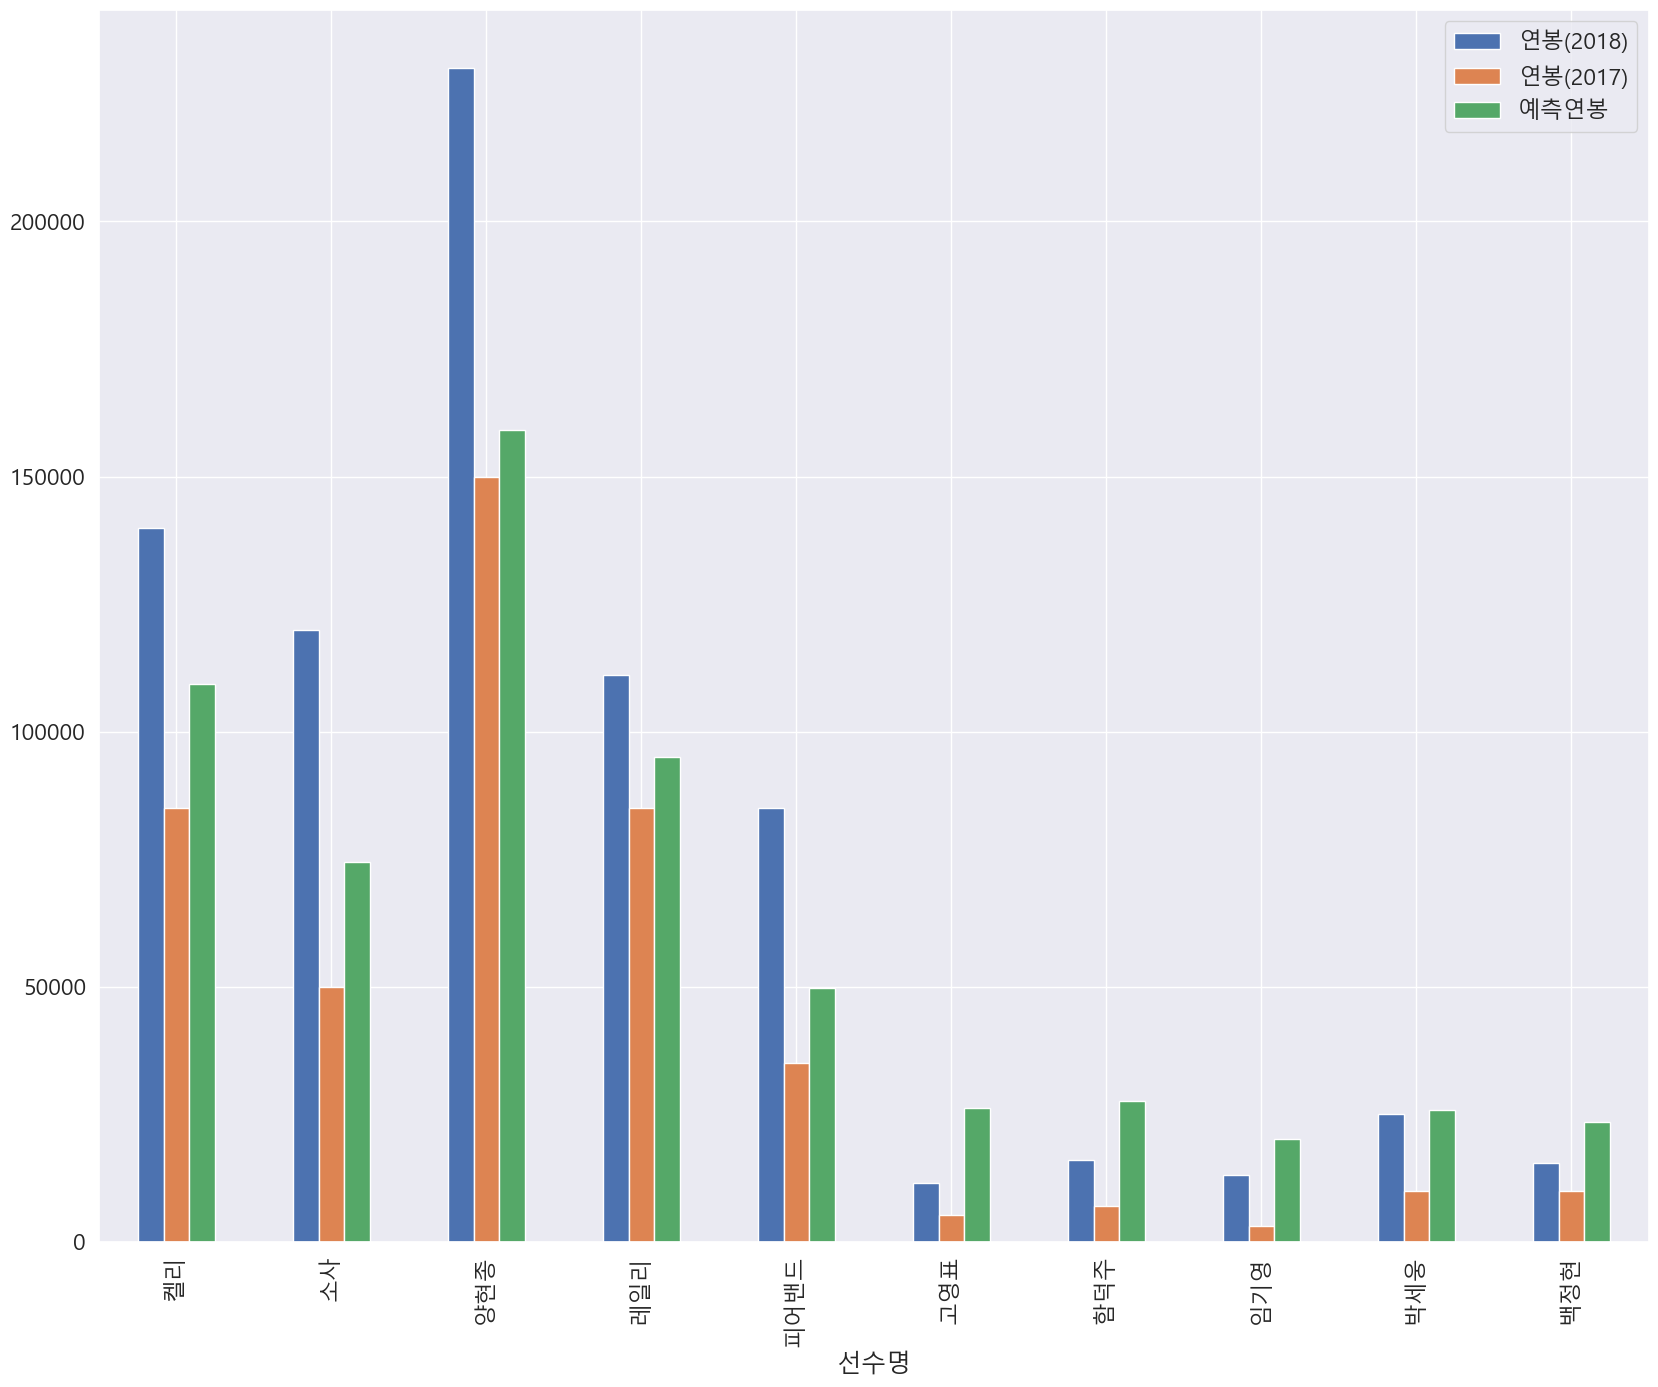

In [52]:
vis_df.head(10).plot(x='선수명', 
                     y=['연봉(2018)', '연봉(2017)', '예측연봉'],
                     kind='bar')
plt.show()

- 이처럼 통계적 기법으로 모델 최적화를 해 나가는 방법을 익히기 !! 